# A Comprehensive Comparison of Classification Algorithms

## Aim
In this project we will be comparing multiple classification algorithms and see which is the best to use on the Wine dataset that is built into scikit-learn. We will be comparing Logistic Regression and Decision Tree (made using scikit-learn), and k-Nearest Neighbours (kNN) and Naive Bayes (made from scratch). We will also be performing cross validation and hyperparameter tuning to optimise the model's parameters. Additionally, we will be analysing each model's complexity by varying their hyperparameters.

# Preparing the Dataset

In this section we will be importing the Wine dataset from scikit-learn and we will split it into training (80%) and testing (20%) sets.

In [404]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter


In [405]:
# load the dataset
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# check for missing values (0 means no missing values for that field)
print(X.isnull().sum())

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# standardise the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


In [406]:
# find the number of entries for each feature

X.count()

alcohol                         178
malic_acid                      178
ash                             178
alcalinity_of_ash               178
magnesium                       178
total_phenols                   178
flavanoids                      178
nonflavanoid_phenols            178
proanthocyanins                 178
color_intensity                 178
hue                             178
od280/od315_of_diluted_wines    178
proline                         178
dtype: int64

From the above, we can see that we have a balanced dataset. Hence, no further data cleaning or pre-processing is needed.

# Exploratory Data Analysis (EDA)

In this section, we will perform an EDA to better understand the data distribution and relationships between the features. We will perform data visualisation to see any trends or relationships better.

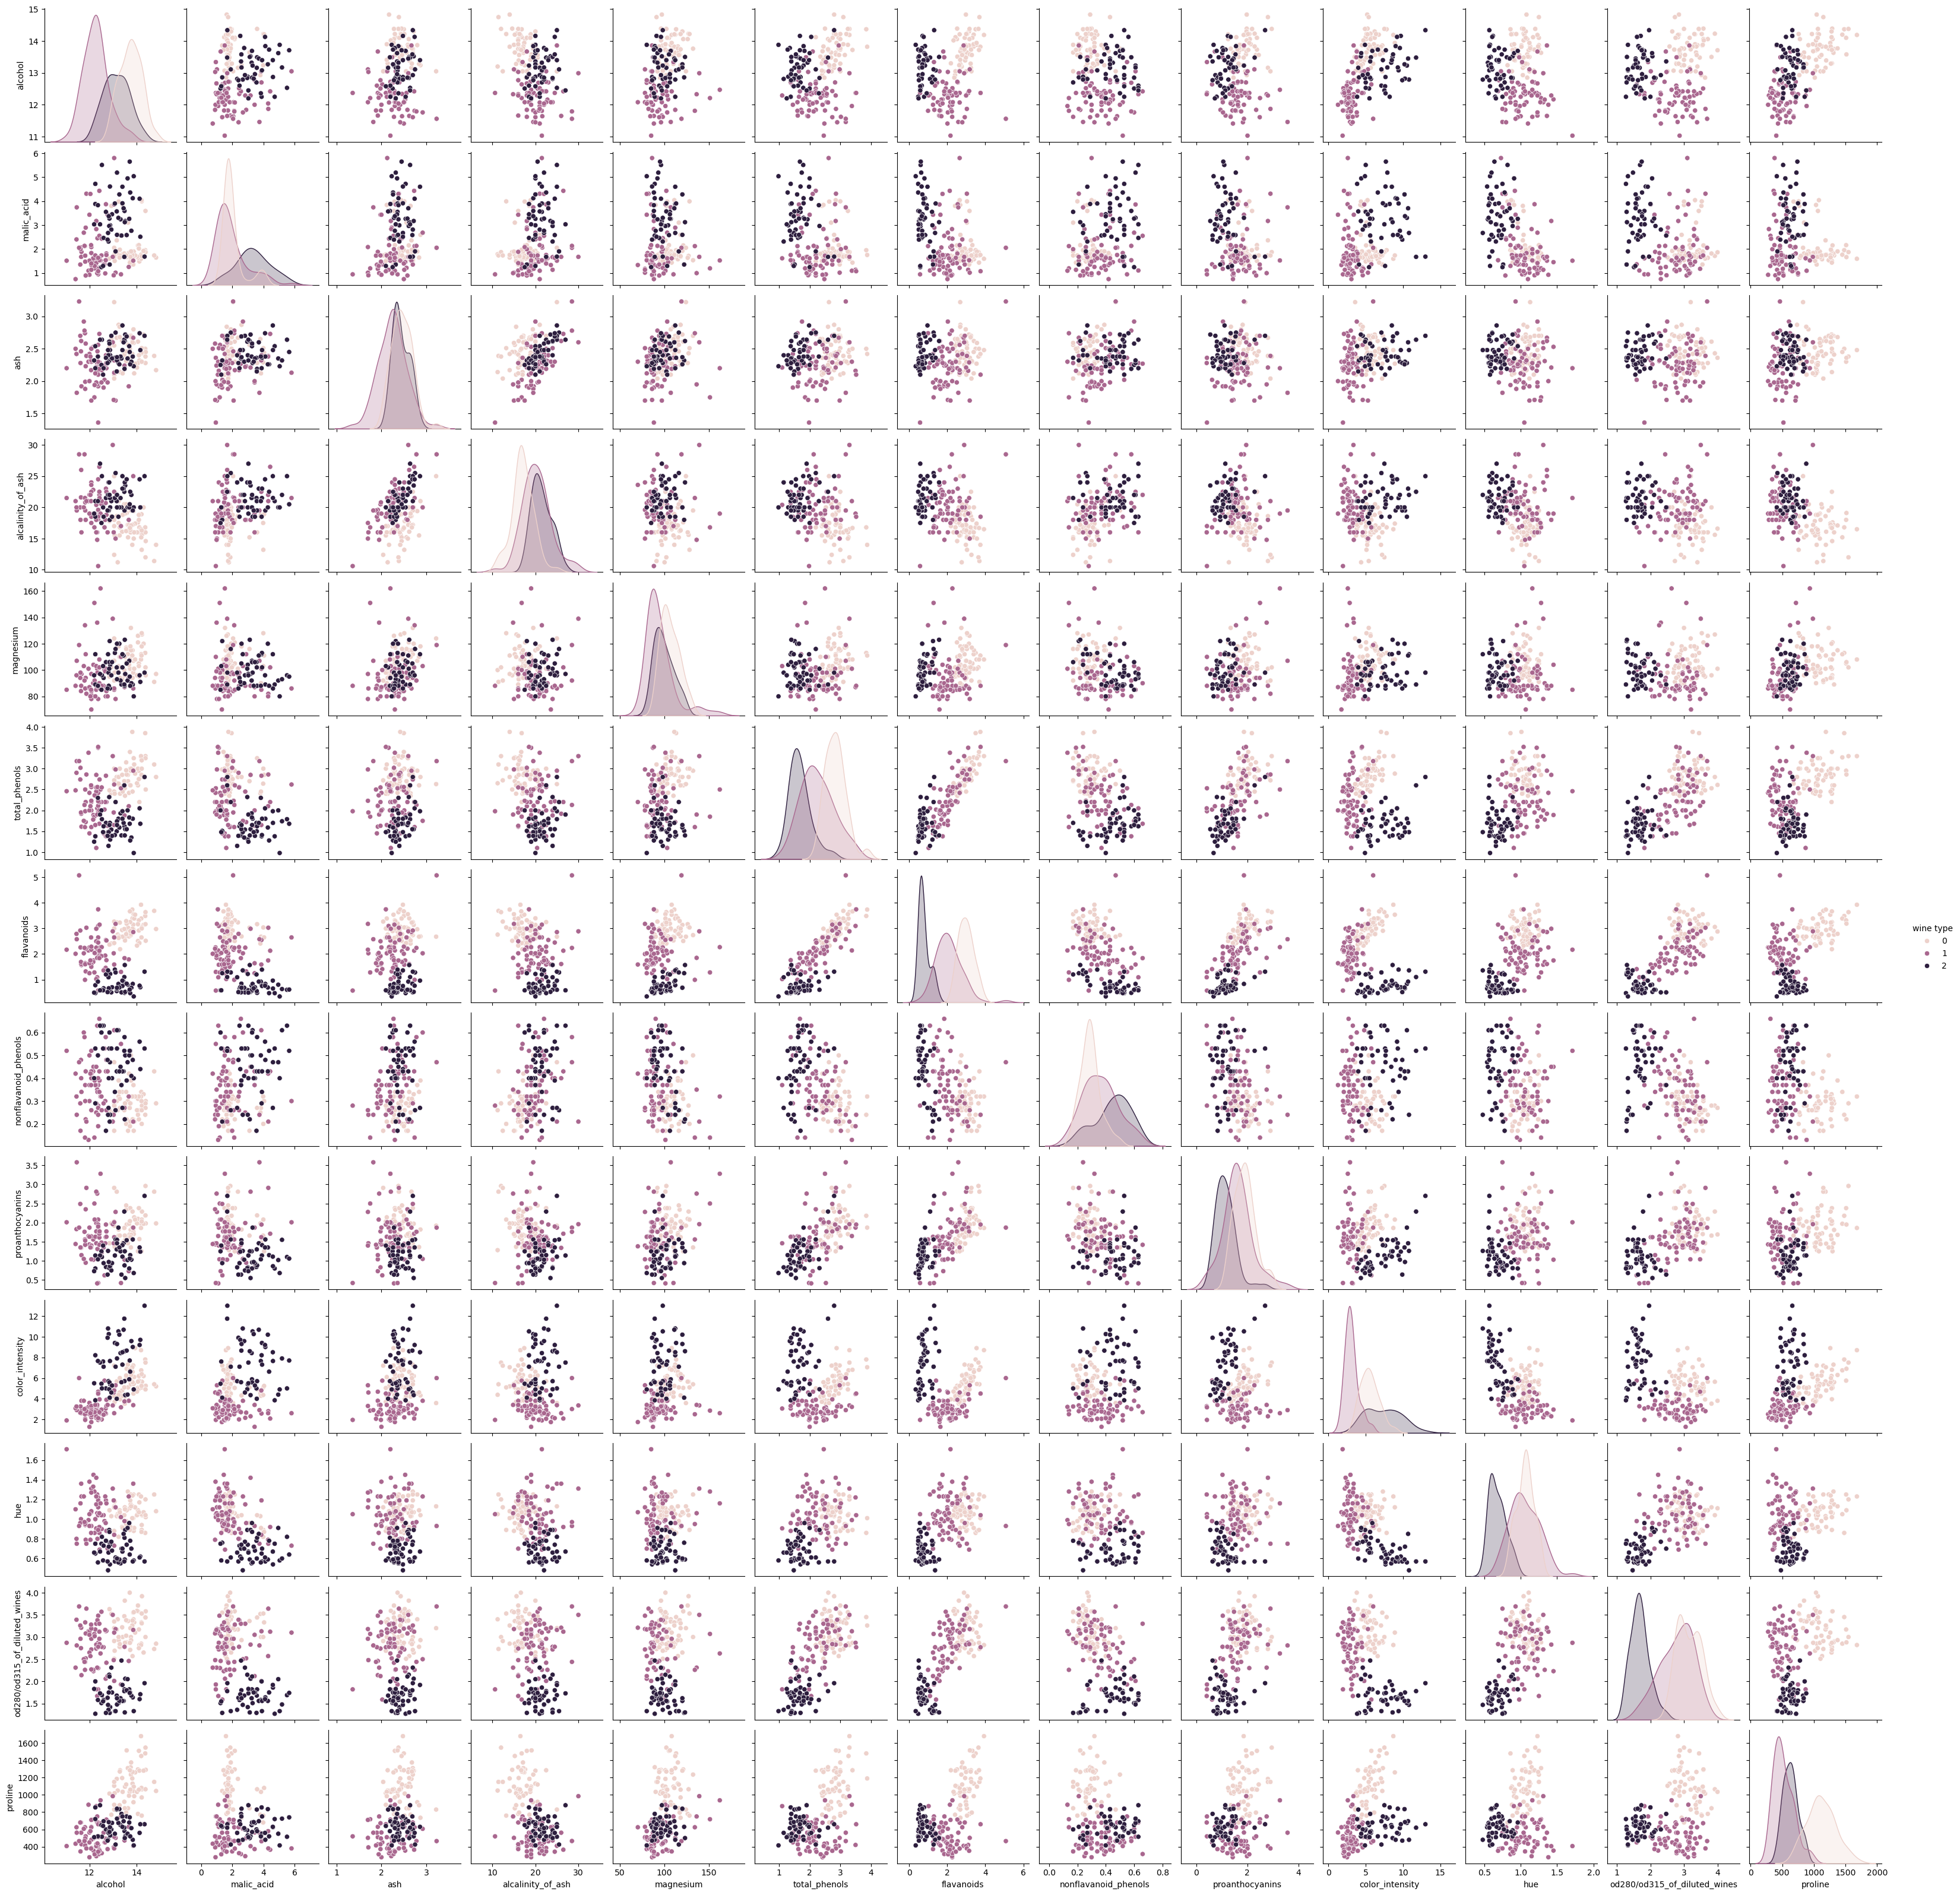

In [407]:
import matplotlib.pyplot as plt
import seaborn as sns

# pair plot for all the 13 features of Wine
sns.pairplot(pd.concat([X.iloc[:, :13], y.rename("wine type")], axis=1), hue="wine type")
plt.show()

The pair plot above shows the relationships of all the features against each other. This helps us identify any patterns between feature pairs and associate them with the respective types of wine (type 0, 1, or 2). 

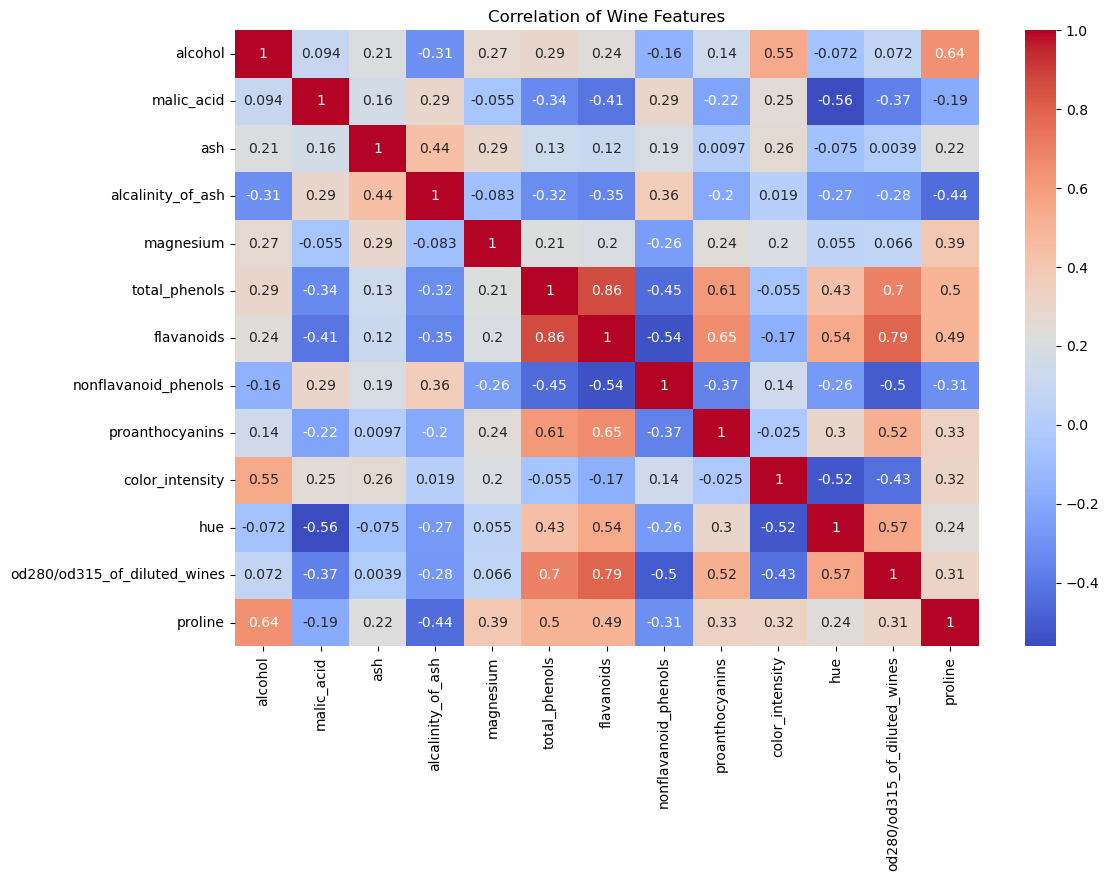

In [408]:
# correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Wine Features")
plt.show()

From the correlation heatmap above, we can better analyse the relationships of feature pairs. The more warm toned the colour (closer to red, more positive value), the more positive the correlation is between the two features. In contrast, the more cool toned the colour (closer to blue, more negative value), the more negative the correlation is between the two features. The closer the value is to zero, the less the correlation between the two features.

Taking examples from the above, we can see that there is a strong positive correlation between the total_phenols and flavanoids at 0.86. This means that the more flavanoids that are present in the wine, the higher the total phenol content. Similarly, there is a strong negative correlation between the hue and malic_acid at -0.56. This means that the higher the malic acid content in the wine, the lighter the hue of the liquid. On the other hand, there is barely any correlation between malic_acid and alcohol at 0.094.

# Implementation and Evaluation of Algorithms

In this section we will be implementing our chosen classification algorithms: k-Nearest Neighbours classification, Naive Bayes classification, Logistic Regression, and Decision Trees. Additionally, we will conduct k-fold cross validation and hyperparemeter tuning to them to be able to yield the best possible results. Afterwards, we will be training and evaluating each model.

For cross validation, we will be splitting the training data into k subsets, training the models on k-1 subsets and testing it on the remaining subset. This process will repeat for every subset. For this project, we will be using k = 5.

For hyperparameter tuning, we will be using GridSearchCV to tune hyperparameters of our Logistic Regression classifier and Decision Tree classifier. GridSearch will search over a specified parameter grid and return the best performing hyperparameters based on cross validation.

For training and evaluation, we will train the respective models using their optimal hyperparameters, and evaluate them on the test data.

### k-Nearest Neighbours (kNN) Classifier
We will be coding this algorithm from scratch using NumPy.

In [409]:
# define the k-NN algorithm
def knn_predict(X_train, y_train, X_test, k):
    predictions = [] # list to store predictions
    for test_point in X_test:
        # compute distances from the test point to all training points
        distances = np.linalg.norm(X_train - test_point, axis=1)
        # get indices of k nearest neighbors
        k_neighbours = np.argsort(distances)[:k]
        # get the labels of the k nearest neighbours
        k_labels = y_train.iloc[k_neighbours]
        # determine the majority vote
        most_common = Counter(k_labels).most_common(1)[0][0]
        predictions.append(most_common)
    return np.array(predictions)


#### Cross Validation

In [410]:
# perform k-fold cross-validation
def cross_validate_with_metrics(X_train, y_train, k_values, num_folds=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    metrics = {k: {"accuracy": [], "precision": [], "recall": [], "f1": []} for k in k_values}
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        for k in k_values:
            y_pred = knn_predict(X_train_fold, y_train_fold, X_val_fold, k)
            metrics[k]["accuracy"].append(np.mean(y_pred == y_val_fold))
            metrics[k]["precision"].append(precision_score(y_val_fold, y_pred, average='weighted'))
            metrics[k]["recall"].append(recall_score(y_val_fold, y_pred, average='weighted'))
            metrics[k]["f1"].append(f1_score(y_val_fold, y_pred, average='weighted'))
    
    avg_metrics = {
        k: {metric: np.mean(values) for metric, values in metrics[k].items()} for k in k_values
    }
    return avg_metrics

#### Hyperparameter: Number of Neighbours (k)

In [411]:
# hyperparameter tuning
k_values = range(1, 21)
avg_metrics = cross_validate_with_metrics(X_train, y_train, k_values)

# find the best k based on accuracy
best_k = max(avg_metrics, key=lambda k: avg_metrics[k]["accuracy"])
print(f"Best k: {best_k}, Metrics: {avg_metrics[best_k]}")


Best k: 19, Metrics: {'accuracy': 0.9721674876847292, 'precision': 0.975039060556302, 'recall': 0.9721674876847292, 'f1': 0.9719805526566343}


#### Training and Evaluation of k-NN Classifier

In [412]:
# train and evaluate on the test set using the best k
y_test_pred = knn_predict(X_train, y_train, X_test, best_k)
test_accuracy = np.mean(y_test_pred == y_test)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test set accuracy with k={best_k}: {test_accuracy}")
print(f"Test set precision with k={best_k}: {test_precision}")
print(f"Test set recall with k={best_k}: {test_recall}")
print(f"Test set F1 score with k={best_k}: {test_f1}")


Test set accuracy with k=19: 1.0
Test set precision with k=19: 1.0
Test set recall with k=19: 1.0
Test set F1 score with k=19: 1.0


From the above, we can see that the highest accuracy score we achieved during cross validation was 0.9721, the highest precision score was 0.9750, the highest recall score is 0.9721, and the highest F1 score is 0.9719 when k = 19. Using the best k (19) on the test set yields an accuracy score of 1.0. This is the highest possible accuracy score.

### Naive Bayes Classifier

We will be coding this algorithm from scratch as well, using NumPy. This will be the Gaussian variant, which will assume that the features of the Wine dataset follow a normal distribution.

In [413]:
# define the Naive Bayes algorithm
class NaiveBayes:
    def __init__(self, smoothing=1e-2):
        self.smoothing = smoothing
        self.classes = None
        self.means = {}
        self.variances = {}
        self.priors = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.means[cls] = np.mean(X_cls, axis=0) # calculates mean
            self.variances[cls] = np.var(X_cls, axis=0) + self.smoothing # calculates variance and applies smoothing to it
            self.priors[cls] = X_cls.shape[0] / X.shape[0] 

    # calculates posterior probability
    def predict(self, X):
        predictions = [] # list to store predictions
        for x in X:
            posteriors = {} 
            for cls in self.classes:
                prior = np.log(self.priors[cls])
                likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.variances[cls]))
                likelihood -= 0.5 * np.sum(((x - self.means[cls]) ** 2) / self.variances[cls])
                posteriors[cls] = prior + likelihood
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)
    
# function to calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    return accuracy, precision, recall, f1

#### Cross Validation

In [414]:
# perform k-fold cross validation
def cross_validate_with_metrics(X, y, num_folds=5, smoothing_values=[1e-2, 1e-3, 1e-4]):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    results = {smoothing: {"accuracy": [], "precision": [], "recall": [], "f1": []} for smoothing in smoothing_values}
    
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        for smoothing in smoothing_values:
            model = NaiveBayes(smoothing=smoothing)
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            accuracy, precision, recall, f1 = evaluate_model(y_val_fold, y_pred)
            results[smoothing]["accuracy"].append(accuracy)
            results[smoothing]["precision"].append(precision)
            results[smoothing]["recall"].append(recall)
            results[smoothing]["f1"].append(f1)
    
    # average metrics for each smoothing value
    avg_metrics = {
        smoothing: {
            "accuracy": np.mean(metrics["accuracy"]),
            "precision": np.mean(metrics["precision"]),
            "recall": np.mean(metrics["recall"]),
            "f1": np.mean(metrics["f1"]),
        }
        for smoothing, metrics in results.items()
    }
    return avg_metrics

#### Hyperparameter: Smoothing Value

In [415]:
# hyperparameter tuning
smoothing_values = [1e-2, 1e-3, 1e-4]
metrics = cross_validate_with_metrics(X_train, y_train, smoothing_values=smoothing_values)

# find the best smoothing parameter based on accuracy score
best_smoothing = max(metrics, key=lambda x: metrics[x]["accuracy"])
print(f"Best smoothing: {best_smoothing}")
print(f"Metrics for best smoothing: {metrics[best_smoothing]}")


Best smoothing: 0.01
Metrics for best smoothing: {'accuracy': 0.9719211822660098, 'precision': 0.9739119555868324, 'recall': 0.9719211822660098, 'f1': 0.9718742459677963}


#### Training and Evaluation of Naive Bayes Classifier

In [416]:
# train and evaluate on the test set using the best smoothing parameter
model = NaiveBayes(smoothing=best_smoothing)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)

print(f"Test set metrics with smoothing={best_smoothing}:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")

Test set metrics with smoothing=0.01:
Accuracy: 0.9722222222222222
Precision: 0.9743589743589745
Recall: 0.9722222222222222
F1 Score: 0.9722633744855966


The result above shows us that the best accuracy score we have achieved during cross validation was 0.9719, the best precision score was 0.9739, the best recall score was 0.9719, and the best F1 score was 0.9718 when the smoothing value was 0.01. Using the best smoothing value (0.01) on our test set yields us an accuracy score of 0.9722.

### Logistic Regression Classifier

We will be implementing this algorithm using scikit-learn.

In [417]:
# implements the algorithm
lr = LogisticRegression(max_iter=1000, random_state=42)


#### Cross Validation and Hyperparameter Tuning (Regularisation (C) and Solver Type)

In [418]:
# perform k-fold cross validation and hyperparameter tuning
def logistic_regression_with_cv(X_train, y_train):
    # dictionary of hyperparameters
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    }

    # scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }

    # GridSearchCV with multiple scoring metrics
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring=scoring, refit='accuracy')
    grid_search.fit(X_train, y_train)
    
    # print the best parameters and scores
    print("Best parameters for Logistic Regression:", grid_search.best_params_)
    print("Best cross-validated accuracy:", grid_search.best_score_)
    
    # access scores for all metrics
    results = grid_search.cv_results_
    print("Cross-validated precision:", np.max(results['mean_test_precision']))
    print("Cross-validated recall:", np.max(results['mean_test_recall']))
    print("Cross-validated F1 score:", np.max(results['mean_test_f1']))
    
    return grid_search.best_estimator_

# get the best logistic regression model
best_lr = logistic_regression_with_cv(X_train, y_train)

Best parameters for Logistic Regression: {'C': 0.01, 'solver': 'lbfgs'}
Best cross-validated accuracy: 0.9862068965517242
Cross-validated precision: 0.9876959247648902
Cross-validated recall: 0.9862068965517242
Cross-validated F1 score: 0.9860805671593974


#### Training and Evaluation of Logistic Regression Classifier

In [419]:
# train and valuate logistic regression on our test set
print("Logistic Regression Test Set Evaluation:")
y_test_pred_lr = best_lr.predict(X_test)

# calculate test set metrics
test_accuracy = accuracy_score(y_test, y_test_pred_lr)
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')
test_f1 = f1_score(y_test, y_test_pred_lr, average='weighted')

# print test set metrics
print("Test set accuracy:", test_accuracy)
print("Test set precision:", test_precision)
print("Test set recall:", test_recall)
print("Test set F1 score:", test_f1)

Logistic Regression Test Set Evaluation:
Test set accuracy: 1.0
Test set precision: 1.0
Test set recall: 1.0
Test set F1 score: 1.0


From the above, we can see that the best parameters for Logistic Regression is a C value of 0.01 and using lbfgs as the solver. During cross validation, our model received 0.9862 as the highest accuracy score, 0.9876 as the highest precision score, 0.9862 as the highest recall score, and 0.9860 as the highest F1 score. Using these parameters caused our model to have the highest possible accuracy of 1.0.

### Decision Tree Classifier

We will also be implementing this algorithm using scikit-learn.

In [420]:
# implements the algorithm
dt = DecisionTreeClassifier(random_state=42)

#### Cross Validation and Hyperparameter Tuning (Maximum Depth (max_depth) and Minimum Samples Per Leaf (min_samples_leaf))

In [421]:
# perform k-fold cross validation and hyperparameter tuning
def decision_tree_with_cv(X_train, y_train):
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 6]
    }

    # scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }

    grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=scoring, refit='accuracy')
    grid_search.fit(X_train, y_train)

# print the best parameters and scores
    print("Best parameters for Logistic Regression:", grid_search.best_params_)
    print("Best cross-validated accuracy:", grid_search.best_score_)
    
    # access scores for all metrics
    results = grid_search.cv_results_
    print("Cross-validated precision:", np.max(results['mean_test_precision']))
    print("Cross-validated recall:", np.max(results['mean_test_recall']))
    print("Cross-validated F1 score:", np.max(results['mean_test_f1']))
    
    return grid_search.best_estimator_

# get the best decision tree model
best_dt = decision_tree_with_cv(X_train, y_train)

Best parameters for Logistic Regression: {'max_depth': None, 'min_samples_leaf': 2}
Best cross-validated accuracy: 0.9233990147783251
Cross-validated precision: 0.9302311481621827
Cross-validated recall: 0.9233990147783251
Cross-validated F1 score: 0.9232289783390548


#### Training and Evaluation of Decision Tree Classifier

In [422]:
# train and evaluate decision tree on our test set
print("Decision Tree Test Set Evaluation:")
y_test_pred_dt = best_dt.predict(X_test)

# calculate test set metrics
test_accuracy = accuracy_score(y_test, y_test_pred_dt)
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')
test_f1 = f1_score(y_test, y_test_pred_dt, average='weighted')

# print test set metrics
print("Test set accuracy:", test_accuracy)
print("Test set precision:", test_precision)
print("Test set recall:", test_recall)
print("Test set F1 score:", test_f1)

Decision Tree Test Set Evaluation:
Test set accuracy: 1.0
Test set precision: 1.0
Test set recall: 1.0
Test set F1 score: 1.0


From the results above, we can see that the best parameters for the Decision Tree is to have a maximum depth of no limit and 2 minimum samples per leaf. During cross validation, our model received 0.9233 as the highest accuracy score, 0.9302 as the highest precision score, 0.9233 as the highest recall score, and 0.9232 as the highest F1 score. Using these parameters caused our model to have the highest possible accuracy of 1.0.

# Model Comparison

In this section, we will be comparing the different models that we have evaluated above. We will be comparing their cross validation results, as well as their test results, in a table for easy viewing. We will also analyse the strengths and weaknesses of each algorithm.

In [423]:
results = {
    'Model': ['k-Nearest Neighbours (from scratch)', 'Naive Bayes (from scratch)', 'Logistic Regression', 'Decision Tree'],
    'Optimal Parameters': ['k = 19', 'smoothing = 0.01', 'C = 0.01, solver = lbfgs', 'max_depth = None, min_samples_leaf = 2'],
    'Accuracy (Validation)': [0.9721674876847292, 0.9719211822660098, 0.9862068965517242, 0.9233990147783251],
    'Precision (Validation)': [0.975039060556302, 0.9739119555868324, 0.9876959247648902, 0.9302311481621827],
    'Recall (Validation)': [0.9721674876847292, 0.9719211822660098, 0.9862068965517242, 0.9233990147783251],
    'F1 (Validation)': [0.9719805526566343, 0.9718742459677963, 0.9860805671593974, 0.9232289783390548],
    'Accuracy': [1.0, 0.9722222222222222, 1.0, 1.0],
    'Precision': [1.0, 0.9743589743589745, 1.0, 1.0],
    'Recall': [1.0, 0.9722222222222222, 1.0, 1.0],
    'F1': [1.0, 0.9722633744855966, 1.0, 1.0]
}

# create the dataframe
results_df = pd.DataFrame(results)

# display table
results_df

Model  \
0  k-Nearest Neighbours (from scratch)   
1           Naive Bayes (from scratch)   
2                  Logistic Regression   
3                        Decision Tree   

                       Optimal Parameters  Accuracy (Validation)  \
0                                  k = 19               0.972167   
1                        smoothing = 0.01               0.971921   
2                C = 0.01, solver = lbfgs               0.986207   
3  max_depth = None, min_samples_leaf = 2               0.923399   

   Precision (Validation)  Recall (Validation)  F1 (Validation)  Accuracy  \
0                0.975039             0.972167         0.971981  1.000000   
1                0.973912             0.971921         0.971874  0.972222   
2                0.987696             0.986207         0.986081  1.000000   
3                0.930231             0.923399         0.923229  1.000000   

   Precision    Recall        F1  
0   1.000000  1.000000  1.000000  
1   0.974359  0.972222  0.972263  
2   1.000000  1.000000  1.000000  
3   1.000000  1.000000  1.000000

### k-Nearest Neighbours (kNN) (from scratch)
##### Strengths: 
From the table above, we can see that it performs very well- with perfect accuracy, precision, recall, and F1 score on the test set. Additionally, it is also easy to understand and implement, making it an easy classification model to use in general.

##### Weaknesses: 
From the table above, its validation performance is slightly lower than logistic regression, but still has high accuracy and precision. Additionally, it has a large computational cost and can be slow when predicting large datasets. Its results also heavily depend on the k value. 

### Naive Bayes (from scratch)
##### Strengths: 
From the table above, it performed reasonably well, especially with the precision and recall being very close to the best models. It also works well with both small and large datasets, as it is fast and efficient, and performs well with limited data if the features are statistically independent.

##### Weaknesses: 
From the table above, it had the lowest accuracy, precision, recall, and F1 score during the test compared to the other three models. Additionally, it assumes that features are independent given the class, which is rarely true in real-world datasets, including our Wine dataset. 

### Logistic Regression
##### Strengths: 
From the table above, it performed the best on both the validation and test sets, achieving perfect results in all of the metrics. It can also support regularisation to handle overfitting.

##### Weaknesses: 
It is sensitive to feature magnitudes hence, standardisation is needed. 

### Decision Tree
##### Strengths:
From the table above, it performed excellently with perfect scores on the test set. Additionally, feature scaling is not required, and it naturally highlights the most important features.

##### Weaknesses:
Its validation performance is significantly lower than the other models, which tells us that there may be potential overfitting or suboptimal hyperparameters.

## Conclusion
Overall, Logistic Regression is the best model as it showed the highest and most consistent performance across all metrics for both validation and test sets. k-Nearest Neighbours comes after that due to the fact that it has a slightly less consistent performance. This is followed by Naive Bayes as it has slightly lower scores compared to the other models on both validation and test sets. Lastly, Decision Trees is the worst model as it showed weakness in cross validation, suggesting to us that it underwent overfitting.


# Analysis of Feature Importance
In this section, we will be analysing which features in the Wine dataset most influence predictions.

### Analysing Feature Importance for the Decision Tree Model

We will be using the feature_importances_ attribute to determine which features are most important for the Decision Tree model.

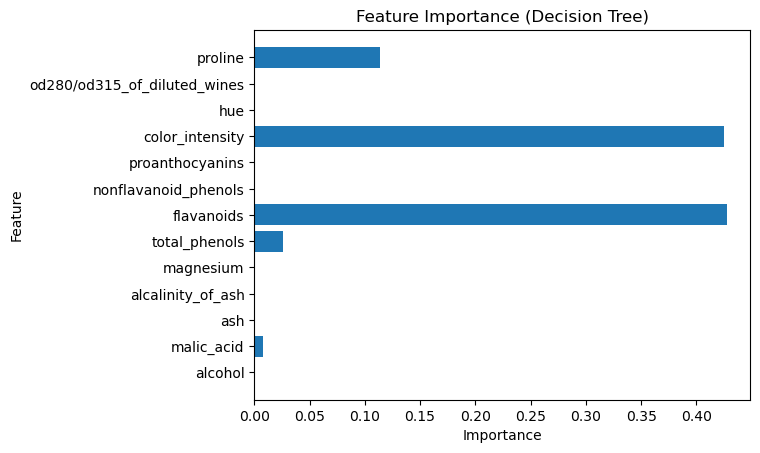

In [424]:
# plot a bargraph to compare each feature's importance
feature_names = data.feature_names
feature_importances = best_dt.feature_importances_
plt.barh(feature_names, feature_importances)
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

From the bar graph above, we can see that the most important feature to use the Decision Tree model on are color_intensity and flavanoids- both of which scored 0.45.

### Analysing Feature Importance for the Logistic Regression Model

We will be using the magnitude of coefficients to determine which features are most important for the Logistic Regression model.

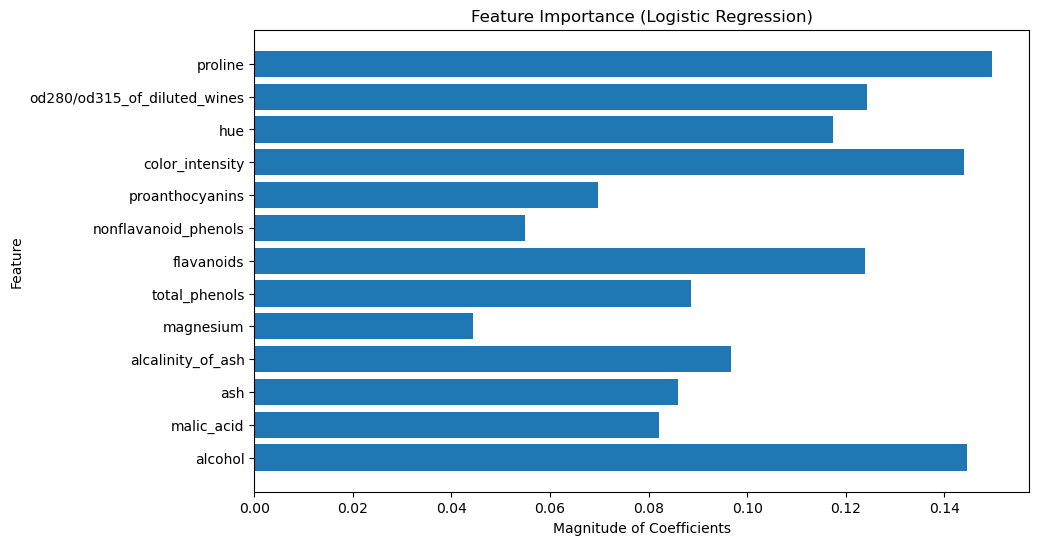

In [425]:
# compute the mean magnitude of coefficients for multi-class
lr_coefficients = np.mean(np.abs(best_lr.coef_), axis=0)

# plot feature importance bar graph
plt.figure(figsize=(10, 6))
plt.barh(feature_names, lr_coefficients)
plt.title("Feature Importance (Logistic Regression)")
plt.xlabel("Magnitude of Coefficients")
plt.ylabel("Feature")
plt.show()

From the bar graph above, we can clealy see that the most important features for Logistic Regression are proline, color_intensity, and alcohol- all scoring above 0.14.

# Analysis of Model Complexity

In this section we will investigate how changes in each model's parameters affect their performance.

### k-Nearest Neighbours (kNN): Changing the k Value

We will investigate how the k value affects the performance of the model.

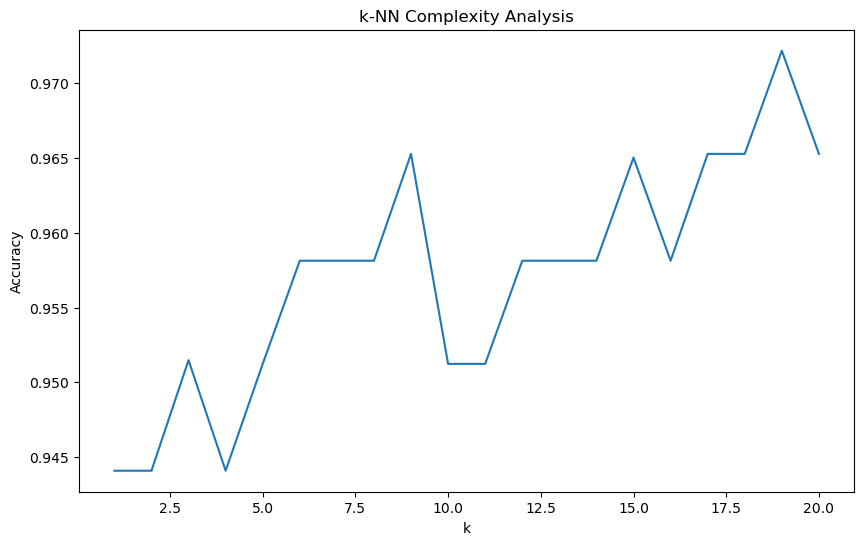

In [426]:
# plot line graph to analyse kNN complexity
k_values = range(1, 21)
k_complexity_results = [avg_metrics[k]["accuracy"] for k in k_values]

# plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_complexity_results)
plt.title("k-NN Complexity Analysis")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()


From the line graph above, we can see that the accuracy of the model fluctuates with different k values. However, it generally increases, with the highest peak being at k = 19.

### Naive Bayes: Changing the Smoothing Value

We will investigate how different smoothing values affect the model's performance.

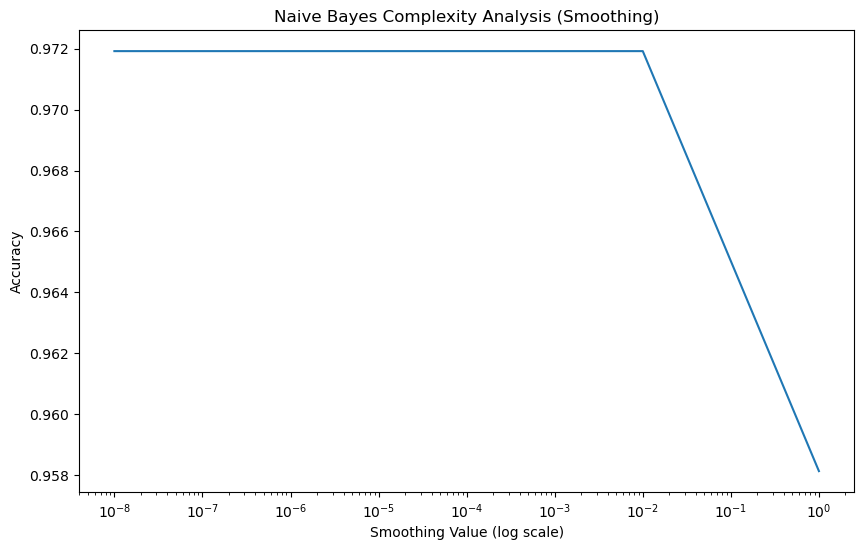

In [427]:
# plot line graph to analyse naive bayes complexity
smoothing_values = [1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1]

nb_complexity_results = {"smoothing": [], "accuracy": []}

for smoothing in smoothing_values:
    model = NaiveBayes(smoothing=smoothing)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        acc, prec, rec, f1_score_val = evaluate_model(y_val_fold, y_pred)
        
        accuracy.append(acc)
    
    nb_complexity_results["smoothing"].append(smoothing)
    nb_complexity_results["accuracy"].append(np.mean(accuracy))

# plot the results
plt.figure(figsize=(10, 6))
for metric in ["accuracy"]:
    plt.plot(nb_complexity_results["smoothing"], nb_complexity_results[metric], label=metric)

plt.xscale("log")
plt.xlabel("Smoothing Value (log scale)")
plt.ylabel("Accuracy")
plt.title("Naive Bayes Complexity Analysis (Smoothing)")
plt.show()


From the line graph above, we can see that as the smoothing value increases past $10^{-2}$ (0.01), the performance of the model goes down as its accuracy score decreases. Any value below 0.01 maintained the model's excellent performance.

### Logistic Regression: Changing the C Values

We will investigate how changing the C value affects the performance of the model.

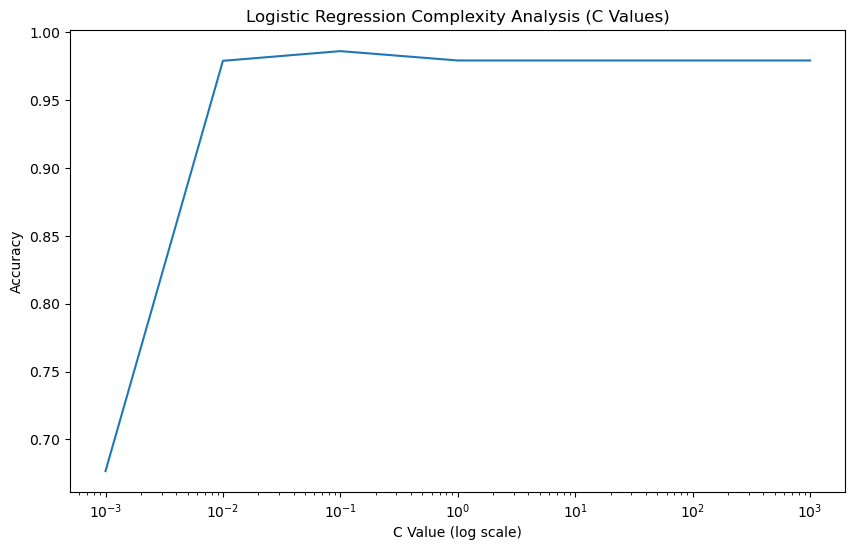

In [428]:
# plot line graph to analyse logistic regression complexity
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
lr_complexity_results = {"C": [], "accuracy": []}

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        acc, prec, rec, f1_score_val = evaluate_model(y_val_fold, y_pred)
        
        accuracy.append(acc)
    
    lr_complexity_results["C"].append(C)
    lr_complexity_results["accuracy"].append(np.mean(accuracy))

# plot the results
plt.figure(figsize=(10, 6))
for metric in ["accuracy"]:
    plt.plot(lr_complexity_results["C"], lr_complexity_results[metric], label=metric)

plt.xscale("log")
plt.xlabel("C Value (log scale)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Complexity Analysis (C Values)")
plt.show()


From the line graph above, we can see that the performance of the model decreases for any C values below $10^{-2}$ (0.01) as its accuracy score goes down. Using C values above 0.01 yielded relatively constant accuracy scores, with 0.1 being slightly higher.

### Decision Trees: Changing the max_depth Value

We will investigate how max_depth impacts how well the model performs while holding other hyperparameters constant.

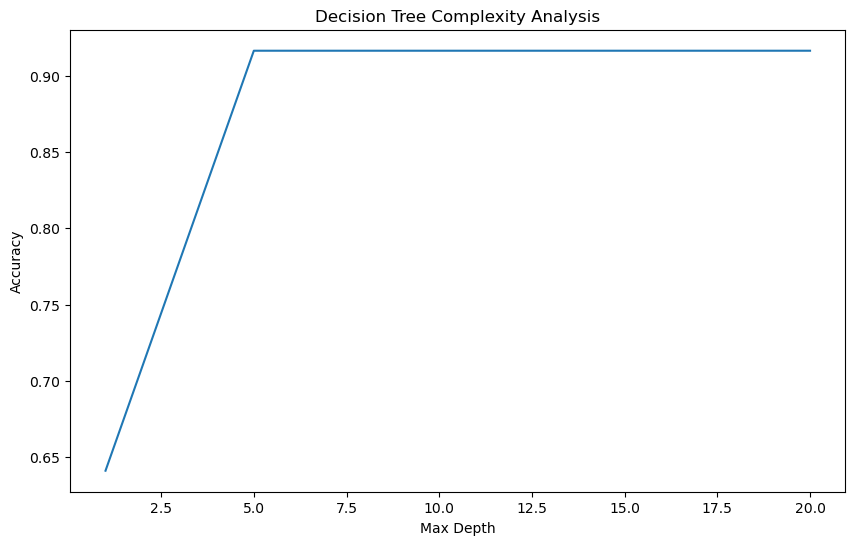

In [429]:
# plot line graph to analyse decision tree complexity
max_depth_values = [None, 1, 5, 10, 15, 20]
dt_complexity_results = []

for depth in max_depth_values:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_validate(dt, X_train, y_train, cv=5, scoring="accuracy")
    dt_complexity_results.append(np.mean(scores['test_score']))

# plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, dt_complexity_results)
plt.title("Decision Tree Complexity Analysis")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()

From the line graph above, we can see that the accuracy score goes down when the max depth value goes below 5. However, the accuracy score remains constant when the max depth value is above 5.